In [1]:
import torch
import os
import h5py
import preprocess
import numpy as np
import matplotlib.pyplot as plt
from utils import SequenceDataset, plot_sample
from tqdm import tqdm
from torch.utils.data import DataLoader
from torch import nn, optim
from pathlib import Path
# Import the necessary classes
from score import ScoreUNet
from score import VPSDE
from score import GaussianScore
import importlib
import score
importlib.reload(score)

<module 'score' from '/home/mtemoschenko/TFE/score.py'>

<h3>Load Model</h3>

In [3]:
checkpoint_path = "slurm/checkpoints/attention_config_spatial_T2m_U10m_2000_2014/attention_config_spatial_T2m_U10m_2000_2014_660.pth"
#checkpoint_path = "slurm/checkpoints/test_attention_config_spatial_T2m_U10m_2000_2014/test_attention_config_spatial_T2m_U10m_2000_2014_60.pth"

In [2]:
import importlib
import score
importlib.reload(score)
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PATH_DATA = Path('./data/processed')
# Load mask
with h5py.File(PATH_DATA / "mask.h5", "r") as f:
    mask = torch.tensor(f["dataset"][:], dtype=torch.float32, device=device).unsqueeze(0)
    mask_cpu = mask.detach().clone().cpu()
if torch.isnan(mask).any():
    raise ValueError("Mask contains NaN values!")
window = 12
# Load dataset to get dimensions
testset = SequenceDataset(PATH_DATA / "test.h5", window=window, flatten=True)

channels, y_dim, x_dim = testset[0][0].shape
print(f"Channels : {channels}")

TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128,128,256],
'attention_levels' : [2],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }

# Model with attention at the bottleneck
'''
TRAIN_CONFIG = {
    "epochs": 10000,
    "batch_size": 5,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    "activation": "SiLU",
    "eta": 5e-3,
}
MODEL_CONFIG = { 'hidden_channels' : [128,256,256,512],
'attention_levels' : [3],
'hidden_blocks' : [2,3,3,3],
'spatial' : 2,
'channels' : channels,
'context' : 4,
'embedding' : 64 }
'''

Using device: cuda


NameError: name 'Path' is not defined

In [5]:
batch_size = TRAIN_CONFIG['batch_size']
testloader = DataLoader(testset, batch_size=batch_size, shuffle=True, num_workers=1, persistent_workers=True)
# Initialize ScoreUNet and VPSDE
score_unet = ScoreUNet(**MODEL_CONFIG).to(device)
vpsde = VPSDE(score_unet, shape=(channels, y_dim, x_dim), eta = TRAIN_CONFIG["eta"]).to(device)
# Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=device)
vpsde.load_state_dict(checkpoint['model_state_dict'])
print(f"Model restored from {checkpoint_path}, trained until epoch {checkpoint['epoch']}")

OutOfMemoryError: CUDA out of memory. Tried to allocate 20.00 MiB. GPU 0 has a total capacity of 10.90 GiB of which 17.12 MiB is free. Process 284179 has 2.54 GiB memory in use. Process 278441 has 8.16 GiB memory in use. Including non-PyTorch memory, this process has 184.00 MiB memory in use. Of the allocated memory 28.51 MiB is allocated by PyTorch, and 3.49 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)

<h3>Load other models </h3>

In [3]:
# Evaluate other model
from utils import ACTIVATIONS
import utils
importlib.reload(utils)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
'''
#Giddy Pond
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 48,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
    #"activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = { 'hidden_channels' : [64, 128, 256, 512, 1024],
'attention_levels' : [4],
'hidden_blocks' : [2,3,3,3,3],
'spatial' : 2,
'channels' : 24,
'context' : 5,
'embedding' : 64}

# Bumbling Snow
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
   # "activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [2,3,4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 128
}

# Fast Silence 89 -> DateEmbedding(x=8, y=8, hidden_dim=32, num_layers=3)
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 128,
    "eta": 5e-3,
    'x' : 64,
    'y' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 128,
    "activation": ACTIVATIONS['SiLU'],
}

# elated deluge 92 -> Construct Naive Context
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 1,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 128,
    "eta": 5e-3,
    'x' : 64,
    'y' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 8,
    'embedding': 128,
    "activation": ACTIVATIONS['SiLU'],
}
'''
# Revivded Glade 93 -> DateEmbedding() 
TRAIN_CONFIG = {
        "window" : 12,
        "epochs": 10000,
        "batch_size": 32,
        "learning_rate": 2e-4,
        "weight_decay": 1e-4,
        "scheduler": "cosine",
        "embedding": 512,
        "eta": 5e-3,
    }
MODEL_CONFIG = {
    'hidden_channels': [128,128,256,384,512],
    'attention_levels': [4],
    'hidden_blocks': [3,3,3,3,3],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 512,
    "activation": ACTIVATIONS['SiLU'],
    'x' : 64,
    'y' : 64
}
'''
# chocolate-feather-97 -> DateEmbedding (Trained on whole dataset)
TRAIN_CONFIG = {
    "window" : 12,
    "epochs": 10000,
    "batch_size": 32,
    "learning_rate": 2e-4,
    "weight_decay": 1e-4,
    "scheduler": "cosine",
    "embedding": 64,
   # "activation": "SiLU",
    "eta": 5e-3,
    'y' : 64,
    'x' : 64
}
MODEL_CONFIG = {
    'hidden_channels': [64, 128, 256, 512, 768],
    'attention_levels': [4],
    'hidden_blocks': [2, 3, 4, 3,2],
    'spatial': 2,
    'channels': 24,
    'context': 5,
    'embedding': 512
}'
'''
# x=8,y=8, hidden_dim=32, num_layers=3
#date_embedding_args = {'x': 8, 'y': 8, 'hidden_dim': 32, 'num_layers': 3}
date_embedding_args = {}
CONFIG = {**TRAIN_CONFIG, **MODEL_CONFIG}
path_data = 'data/processed'
#path_model = 'checkpoints/bumbling-snow-84_2nueyyzk/model_160.pth' 
#path_model = 'checkpoints/fast-silence-89_coqy9s8u/model_10.pth'
#path_model = 'checkpoints/elated-deluge-92_vwboono4/model_70.pth'
path_model = 'checkpoints/revived-glade-93_b1ergcxy/model_240.pth'
# path_model = 'checkpoints/chocolate-feather-97_hrpospoo/model_150.pth'

PATH_DATA = Path('./data/processed')
giddy_pond_setup = utils.load_setup(CONFIG, path_data, path_model, device, date_embedding=True, multi_gpu=True, date_embedding_args=date_embedding_args)

Using device: cuda
Loaded Date Embedding
Model restored from checkpoints/revived-glade-93_b1ergcxy/model_240.pth, trained until epoch 240


In [4]:
testloader, vpsde, mask, mask_cpu = giddy_pond_setup['validloader'], giddy_pond_setup['vpsde'], giddy_pond_setup['mask'], giddy_pond_setup['mask_cpu']
date_embedding = giddy_pond_setup['date_embedding']

<h3>Playgound</h3>

In [5]:
weather_station = (torch.rand(64,64) < 0.005) * mask_cpu


In [7]:
indices = torch.nonzero(weather_station.detach().cpu()[0]).cpu()
#print(weather_station.shape)

print(weather_station.detach().cpu()[..., indices[:,0], indices[:,1]].shape)


torch.Size([1, 14])


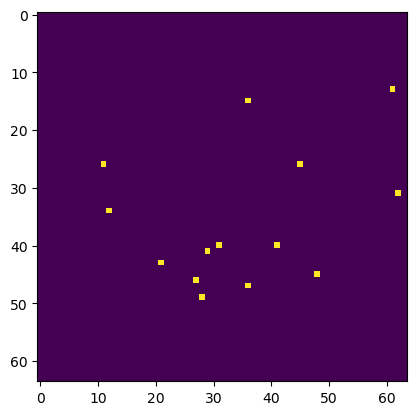

In [6]:
plt.imshow(weather_station[0].detach().cpu())
plt.show()

In [8]:
batch, dic = next(iter(testloader))
print(batch.shape)
print(batch.detach().cpu()[..., indices[:,0], indices[:,1]].shape)


torch.Size([32, 24, 64, 64])
torch.Size([32, 24, 14])


In [9]:
sparsed_batch = batch * weather_station

Loaded lat/lon grid with shape: (64, 64)
T2m  Mean : 3.9123897552490234, Var: 1.39577054977417
U10m  Mean : 3.9414868354797363, Var: 1.1596375703811646


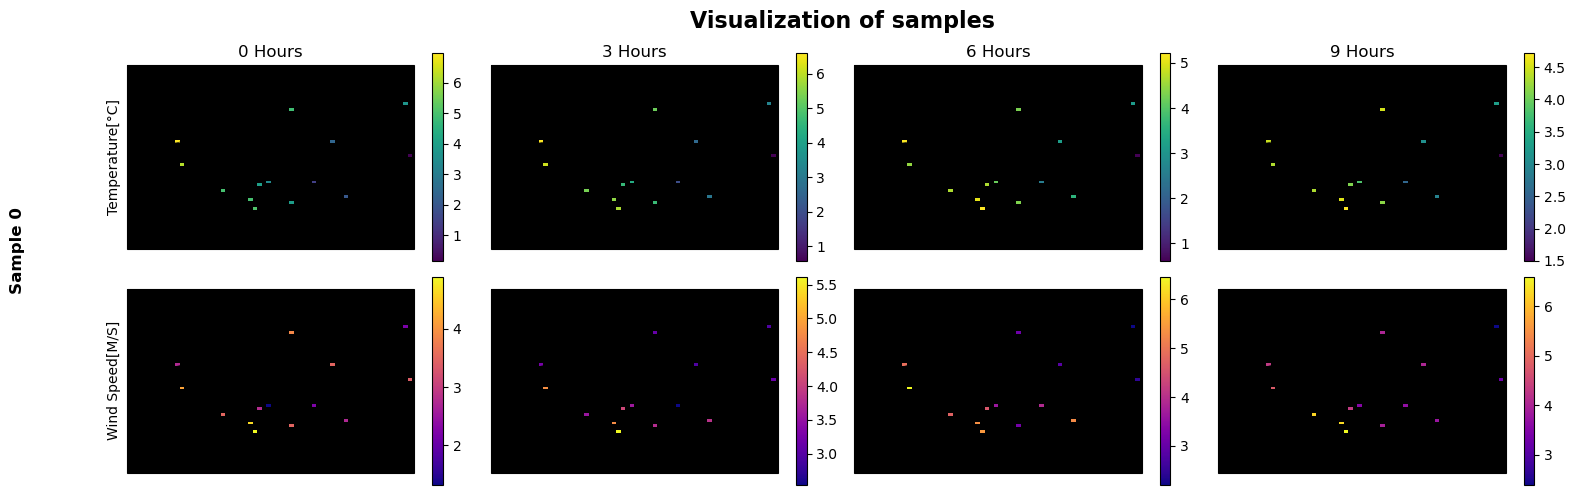

In [10]:
import utils
importlib.reload(utils)
path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = utils.plot_sample(sparsed_batch.cpu(),info,weather_station.cpu(),samples=1,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [12]:
def sparse_belgium(batch, mask):
    return batch*mask.cuda()
def sparse_idx(batch, idx):
    return batch[..., idx[:,0], idx[:,1]]
'''
def sparse_idx(batch, idx):
    result = torch.zeros_like(batch)
    rows = idx[:, 0]
    cols = idx[:, 1]
    mask = torch.zeros(batch.shape[-2:], dtype=torch.bool, device=batch.device)
    mask[rows, cols] = True
    result = torch.where(mask.unsqueeze(0).unsqueeze(0), batch, result)
    return result
'''
def A(x):
    #return sparse_belgium(x, weather_station)
    return sparse_idx(x, indices)
print(indices.shape)

torch.Size([14, 2])


Loaded lat/lon grid with shape: (64, 64)
T2m  Mean : 3.722259998321533, Var: 2.015798568725586
U10m  Mean : 5.635639190673828, Var: 1.3882887363433838


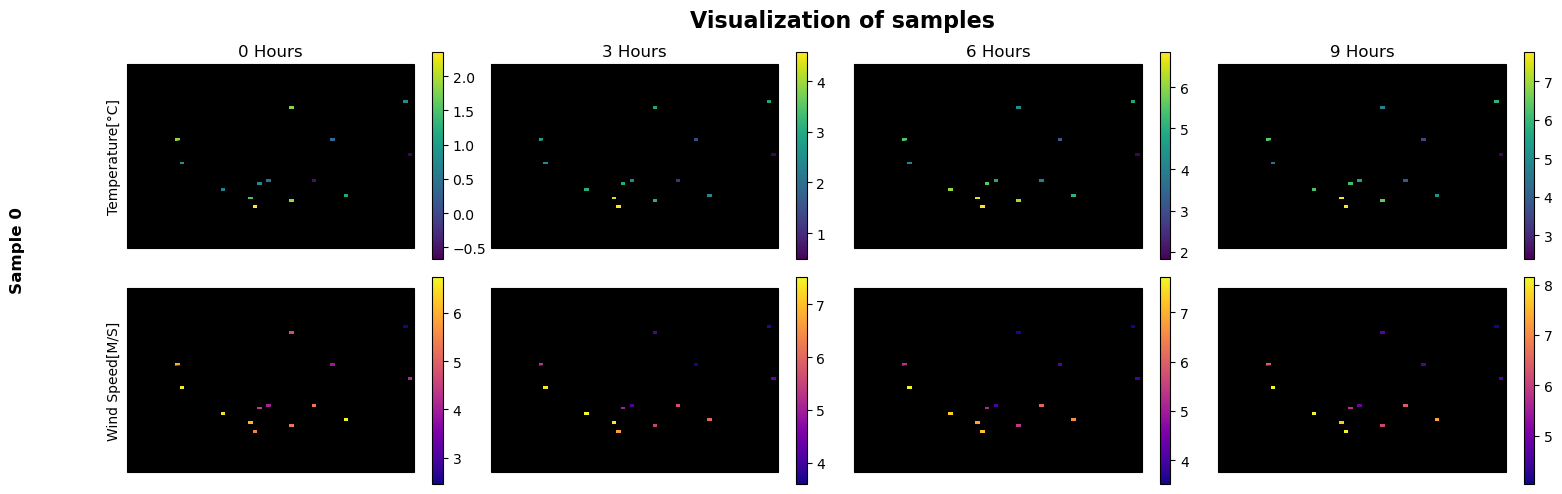

In [13]:
x_star, dic_star = next(iter(testloader))
x_star = x_star.to(device)
c_star = utils.constructEmbedding(date_embedding, dic_star).to(device)
y_star = torch.normal(A(x_star), 1e-3)

info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = plot_sample(x_star.detach().cpu(),info,weather_station.detach().cpu(),samples=1,step=3, unnormalize=True, path_unnorm = path_unnorm)

In [14]:
#importlib.reload(score)
# sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=1), shape=x_star.shape).cuda()
importlib.reload(score)
#sde = VPSDE(score.DPSGaussianScore(y_star,mask, A=A,  sde=vpsde, zeta=4.7), shape=x_star.shape).cuda()
sde = VPSDE(score.GaussianScore(y_star, mask, A=A, std=1e-3, sde=vpsde, gamma=0.1), shape=x_star.shape).cuda()

In [15]:
#x = sde.sample(mask,shape=(1,), c=c_star, steps=64, corrections=8, tau=0.5).cpu()
num_samples = 1
# 512 steps with 2 corrections works well for multiple bacthes and 1 sample and gamma = 0.15
x = sde.sample(mask,shape=(num_samples,), c=c_star, steps=512, corrections=2, tau=0.5).cpu()


100%|█████████████████████████████████████████████████| 512/512 [04:00<00:00,  2.13it/s]


Loaded lat/lon grid with shape: (64, 64)
T2m  Mean : 3.494868516921997, Var: 1.879860281944275
U10m  Mean : 5.415553569793701, Var: 1.1919177770614624
T2m  Mean : 10.356941223144531, Var: 0.4874390661716461
U10m  Mean : 4.014494895935059, Var: 0.1499100923538208
T2m  Mean : 3.240177631378174, Var: 1.7254981994628906
U10m  Mean : 4.744982719421387, Var: 1.6426833868026733
T2m  Mean : 12.350522994995117, Var: 1.5818276405334473
U10m  Mean : 6.592822074890137, Var: 1.8982415199279785
T2m  Mean : 10.40011978149414, Var: 0.1844770759344101
U10m  Mean : 4.017754077911377, Var: 0.18959559500217438
T2m  Mean : 12.560736656188965, Var: 1.6267976760864258
U10m  Mean : 6.326809406280518, Var: 2.1468405723571777
T2m  Mean : 13.96566104888916, Var: 2.1599984169006348
U10m  Mean : 3.0881447792053223, Var: 1.2781683206558228
T2m  Mean : 10.407429695129395, Var: 0.29531171917915344
U10m  Mean : 4.001983642578125, Var: 0.11129668354988098
T2m  Mean : 13.513318061828613, Var: 2.305183172225952
U10m  Mea

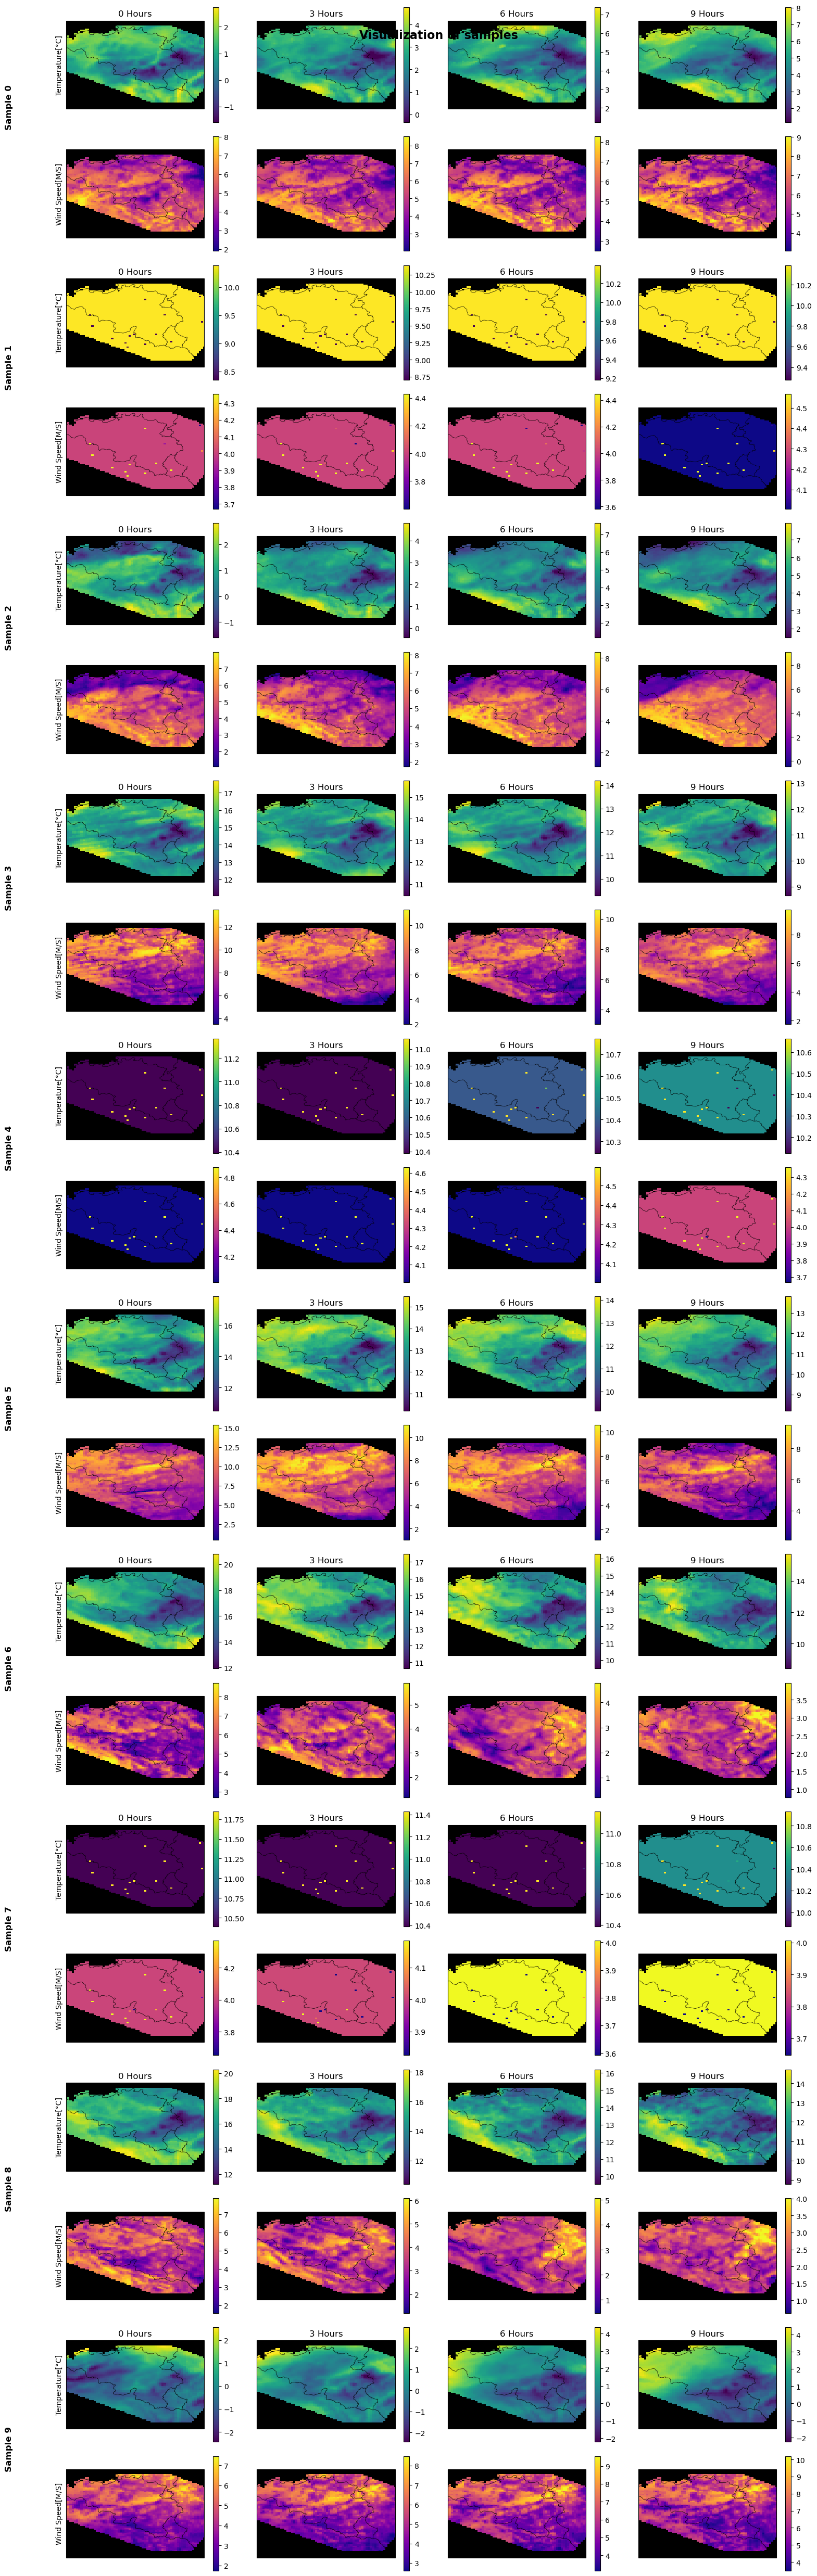

In [16]:
import utils 
importlib.reload(utils)

# If multiple batch and 1 samples squeeze(0), if multiple samples for 1 batch : squeeze(1)
x_ = x.squeeze(0)
#x_ = x.squeeze(1)


# Good parameters : zeta: 4.5, steps: 48, corrections: 3
# Good parameters : zeta= 4.7, steps = 64, corrections = 8, tau = 0.5
# Nice parameters : p = 0.05 zeta = 25, steps = 64, corrections = 8
# For p = 0.01 : zeta = 11, steps = 64, corrections = 8


# 1) multiples batches and 1 sample, 2) 1 batch and multiple samples
new_tensor = torch.stack([x_star.detach().cpu(),(x_star.detach().cpu()*weather_station),x_.detach().cpu() ], dim=1).flatten(0,1)
#new_tensor = torch.cat([x_star.detach().cpu(),(x_star.detach().cpu()*weather_station), x_.detach().cpu()]).cpu()


path_unnorm = PATH_DATA/ "train.h5"
info  = {'var_index': ['T2m', 'U10m'], 'channels' : 2, 'window' : 12}
fig = utils.plot_sample(new_tensor,info,mask_cpu,samples=10,step=3, unnormalize=True, path_unnorm = path_unnorm, show_borders=True)

<h4>Spectral Analysis of Ground Truth and generated Samples</h4>

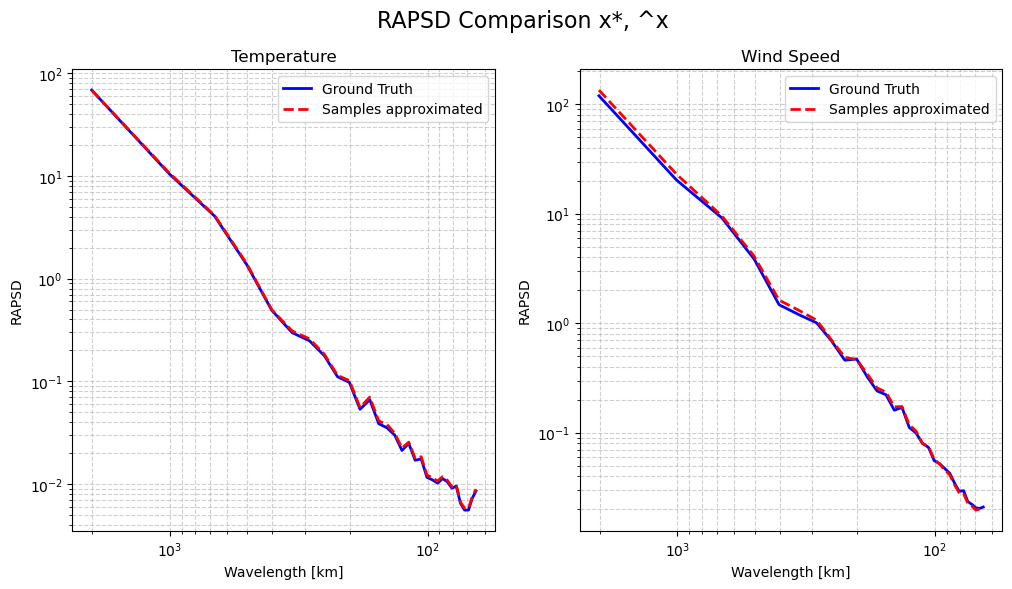

In [18]:
import metrics
importlib.reload(metrics)
wavelengths_x_star, radii,  avg_rapsd_x_star, channel_rapsds = metrics.compute_rapsd(x_star, 5)
wavelengths_x_, _, avg_rapsd_x_, _ = metrics.compute_rapsd(x_, 5)

channel_names = ["Temperature", "Wind Speed"]
title =  f"RAPSD Comparison x*, ^x"
figsize  = (12, 6)
fig, axes = plt.subplots(1, len(channel_names), figsize=figsize)
if len(channel_names) == 1:
    axes = np.array([axes])

mean_rapsd_x_star = np.mean(avg_rapsd_x_star.squeeze(2), axis=0)
mean_rapsd_x_ = np.mean(avg_rapsd_x_.squeeze(2), axis=0)
#mean_rapsd_y_star = np.mean(avg_rapsd_y_star.squeeze(2), axis=0)
for i, name in enumerate(channel_names):
    ax = axes[i]
    ax.loglog(wavelengths_x_star, mean_rapsd_x_star[i], 'b-', label='Ground Truth', linewidth=2)
    ax.loglog(wavelengths_x_, mean_rapsd_x_[i], 'r--', label='Samples approximated', linewidth=2)
    ax.xaxis.set_inverted(True)
    ax.set_xlabel('Wavelength [km]')
    ax.set_ylabel('RAPSD')
    ax.set_title(name)
    ax.grid(True, which="both", ls="--", alpha=0.6)
    ax.legend()

# Add overall figure title
fig.suptitle(title, fontsize=16)
# Add space for the title

plt.show()

In [19]:
import metrics
importlib.reload(metrics)
rmse = metrics.calculate_rmse(x_.detach().cpu(), x_star.detach().cpu(), mask_cpu)
print(rmse['per_variable'])

tensor([0.1369, 0.5173])


<h3>Compare A(Ground Truth) and A(samples)</h3>

In [21]:
y_pred = torch.normal(A(x_.cuda()), 1e-3).cpu()
y_star = torch.normal(A(x_star.cuda()), 1e-3).cpu()
y_random = torch.randn(y_star.shape)
rmse_dic = metrics.calculate_rmse(y_pred.unsqueeze(3).detach().cpu(), y_star.unsqueeze(3).detach().cpu())
print(f"RMSE A(x*) vs A(x^) : {rmse_dic['per_variable']}")

RMSE A(x*) vs A(x^) : tensor([0.0044, 0.0213])
